In [1]:
import scCube
from scCube import scCube
from scCube.visualization import *
from scCube.utils import *
from matplotlib.pyplot import rc_context
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")
from pathlib import Path

In [2]:
model = scCube()

In [3]:
# demo_sc_data.csv and demo_sc_meta.csv are downloaded from https://github.com/ZJUFanLab/scCube/tree/main/tutorial/demo_data
sc_data = pd.read_csv("./demo_sc_data.csv", index_col=0)
sc_meta = pd.read_csv("./demo_sc_meta.csv", index_col=0)

sc_adata = model.pre_process(sc_data=sc_data, 
                             sc_meta=sc_meta,
                             is_normalized=False)

the input is count matrix, normalizing it firstly...


In [4]:
save_path = "/slurm/home/yrd/liaolab/chenrenjie/Benchmark/Simulations/"

In [5]:
generate_sc_meta, generate_sc_data = model.train_vae_and_generate_cell(
    sc_adata=sc_adata,
    celltype_key='Cell_type',
    cell_key='Cell',
    target_num=dict(sc_meta.Cell_type.value_counts() * 5), # target number of cells to generate, if `target_num=None`, generate cells by the proportion of cell types of the input data
    batch_size=512,
    epoch_num=10000,
    lr=0.0001,
    hidden_size=128,
    save_model=True,
    save_path=save_path,
    project_name='sim1',
    used_device='cuda:0')

generating by the targeted proportion of cell types...
begin vae training...


Train Epoch: 9999: 100%|██████████| 10000/10000 [01:54<00:00, 87.20it/s, loss=0.1138, min_loss=0.1136]


vae training done!
saving the trained vae model...
save trained vae in /slurm/home/yrd/liaolab/chenrenjie/Benchmark/Simulations/sim1.pth.


Generate Epoch: 4: 100%|██████████| 2040/2040 [00:00<00:00, 14108.38it/s]


generated done!
data have been prepared!


In [7]:
generate_sc_data_new, generate_sc_meta_new = model.generate_pattern_random(
    generate_sc_data=generate_sc_data,
    generate_sc_meta=generate_sc_meta,
    set_seed=True,
    seed=12345,
    spatial_cell_type=None,
    spatial_dim=2,
    spatial_size=50,
    delta=15, # deltals = [15, 25, 35, 45, 55]
    lamda=0.2, # lamdals = [0.2, 0.4, 0.6, 0.8, 1]
)

generating spatial coordinates of single cells...
generating spatial patterns of totally 4 cell types...


generating spot-based ST data with 0.8 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...


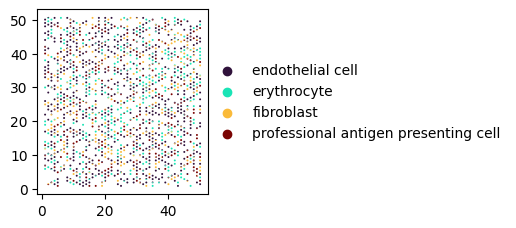

In [8]:
# 10X Visium
st_data, st_meta, st_index = model.generate_spot_data_random(
    generate_sc_data=generate_sc_data_new,
    generate_sc_meta=generate_sc_meta_new,
    platform='Visium',
    gene_type='whole', 
    n_cell=0.8
)
prop = calculate_spot_prop(
    obj=st_index,
    cell_id='Cell',
    label='Cell_type',
    spot_id='spot')

plot_spot_scatterpie(
    obj=prop,
    figwidth=2.2,
    figheight=2.4,
    x="spot_x",
    y="spot_y",
    colormap='turbo',
    res=50,
    direction="+",
    start=0.0,
    size=2,
    edgecolor="none")
plt.show()

In [10]:
cell_type_counts = st_index.groupby(['spot', 'Cell_type']).size().reset_index(name='count')
dominant_cell_type = cell_type_counts.sort_values(['spot', 'count'], ascending=[True, False]).drop_duplicates('spot')
dominant_cell_type = dominant_cell_type[['spot', 'Cell_type']].rename(columns={'Cell_type': 'dominant_Cell_type'})
generate_meta = st_meta.merge(dominant_cell_type, on='spot', how='left')
generate_index = st_index.set_index('spot')
generate_meta['col'] = generate_meta['spot_x'].astype(int)
generate_meta['row'] = (generate_meta['spot_y'] * 2 - 1).astype(int)

adata = sc.AnnData(st_data.T)
adata.var_names_make_unique()
generate_meta = generate_meta.set_index('spot')
adata.obs['col'] = adata.obs.index.map(generate_meta['col'])
adata.obs['row'] = adata.obs.index.map(generate_meta['row'])
adata.obs['ground_truth'] = adata.obs.index.map(generate_meta['dominant_Cell_type']).astype("category")
coor_df = adata.obs[["col","row"]]
adata.obsm["spatial"] = coor_df.to_numpy()   

In [12]:
adata.write_h5ad(f"{save_path}/adata.h5ad")